In [276]:
import numpy as np
import matplotlib.pyplot as plt
import time
#%matplotlib inline

In [344]:
# simulation time
sim_time = 40
time_step = 0.5

In [447]:
QC = 3
P_in = np.ones((32,2))
#QC cells don't have intake of PIN proteins (?)
P_in[QC,:] = [0,0]
# opposite direction in the bottom cells
P_in[0:QC,:] = [0,1]
P_in[QC+1:, 0] = 0.8
P_in[QC+1:, 1] = 0.2

In [448]:
P_out = np.zeros((32,2))
P_out[QC,:] = [1,1]
# opposite direction in the bottom cells
P_out[0:QC,:] = [0.8,0.2]
P_out[QC+1:, 0] = 0.2
P_out[QC+1:, 1] = 0.8

In [453]:
# (1) d(Auxin)/dt = D*sum_neighbours(A_in - A_out) + T*sum_neighours(A_in*P_in - A_out*P_out)

# min(D*value, upper_bound)


def update(cells, source=QC, source_val=100, D=0.25, T=0.5, P_in=P_in, P_out=P_out):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_in : numpy matrix (n_cells,2), amount of PIN1 that a cell intakes from every neighbour (from the front or the back)
    P_out : numpy matrix (n_cells,2), amount of PIN1 that a cell outtakes to every neighbour (to the front or the back)
    """
    # define neighbours
    v = np.array([-1,1])
    updated_cells = np.zeros((len(cells),1))
    for index, value in enumerate(cells):
        # extract neighbours from all cells
        neighbours = cells[list(filter(lambda x: x >= 0 and x < len(cells), v + index))]
        diffusion_in = D*(sum(neighbours))
        diffusion_out = -D*value*len(neighbours)
        # if it's at the ends
        if neighbours.shape[0] == 1:
            transport_in = T*sum(P_in[index,:])*neighbours
            transport_out = T*sum(P_out[index,:])*neighbours
        else:
            transport_in = T*np.dot(P_in[index,:],neighbours)
            transport_out = T*sum(P_out[index,:])*value
        step = transport_in + transport_out + diffusion_in + diffusion_out
        # we update only if the concentration is increased, add 0 otherwise
        if step < 0:
            step = 0
        # adding source
        updated_cells[index,0] = step
    updated_cells[source] += source_val
    return updated_cells

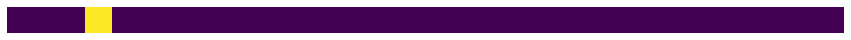

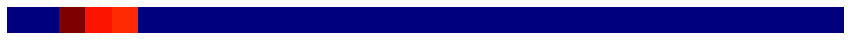

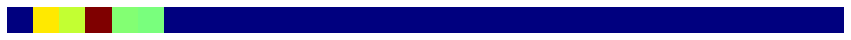

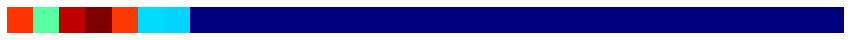

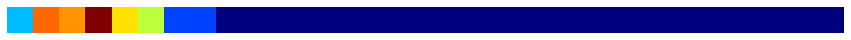

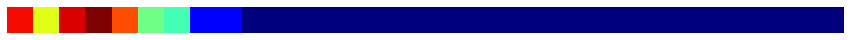

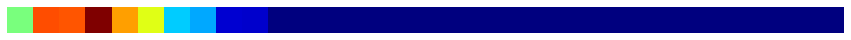

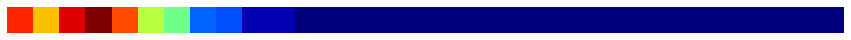

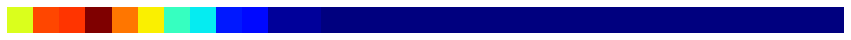

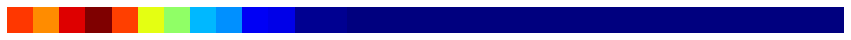

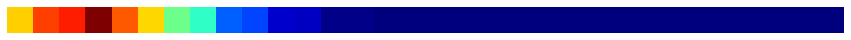

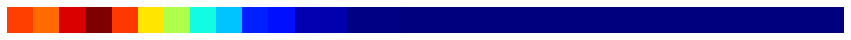

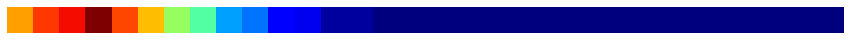

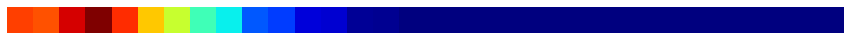

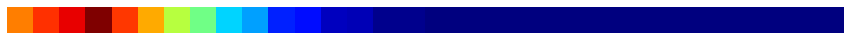

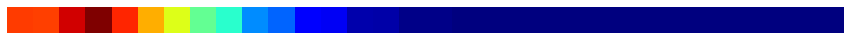

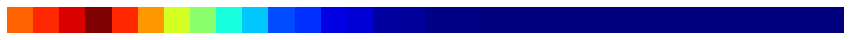

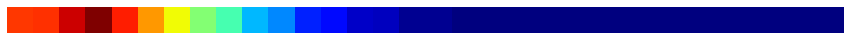

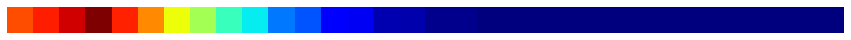

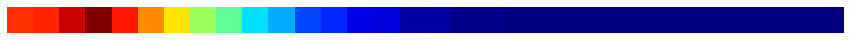

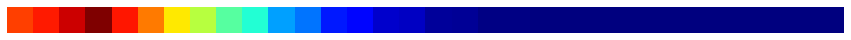

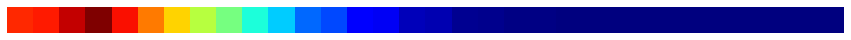

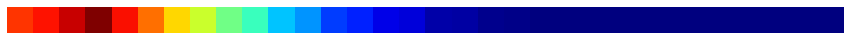

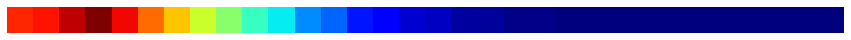

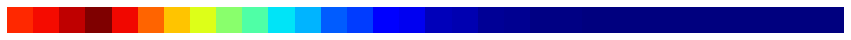

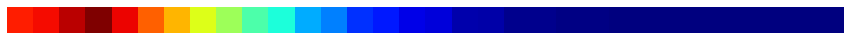

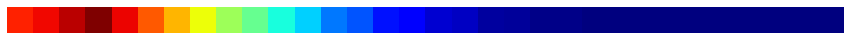

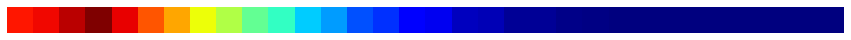

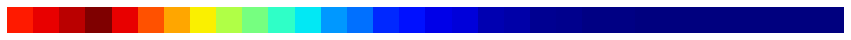

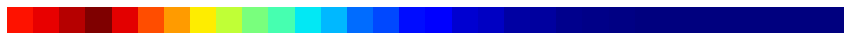

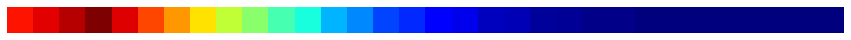

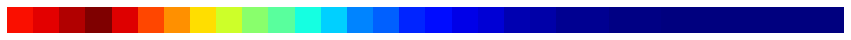

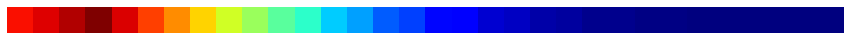

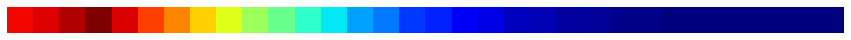

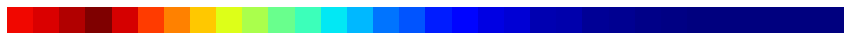

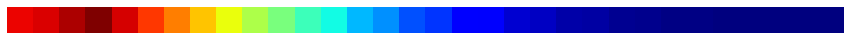

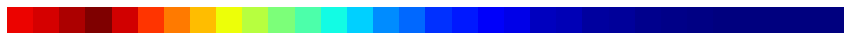

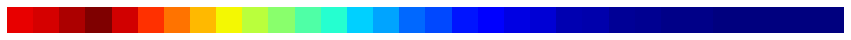

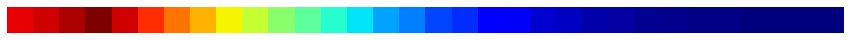

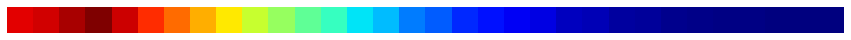

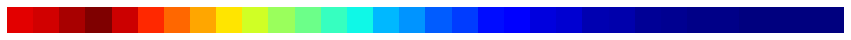

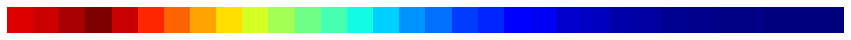

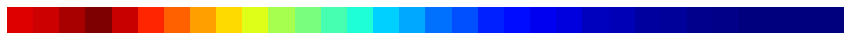

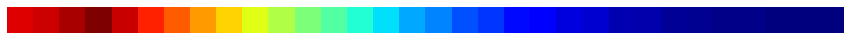

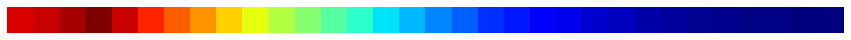

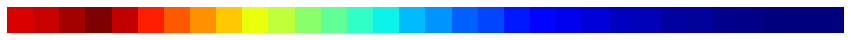

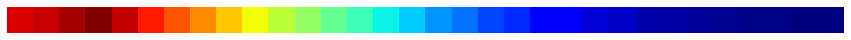

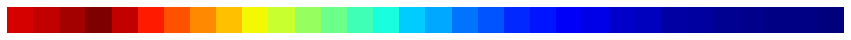

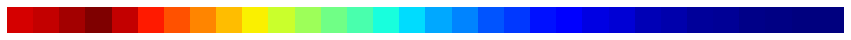

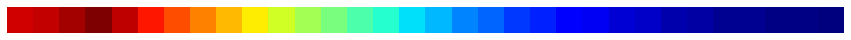

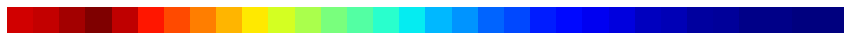

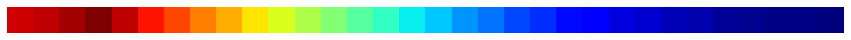

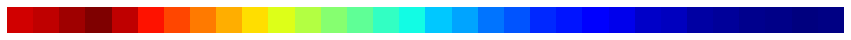

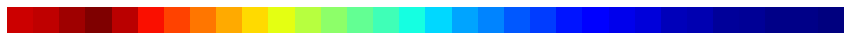

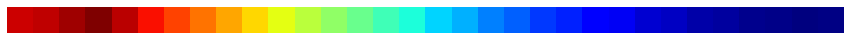

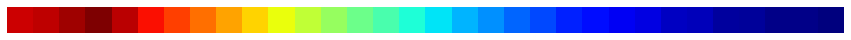

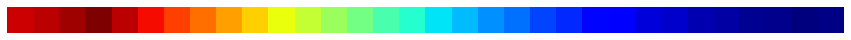

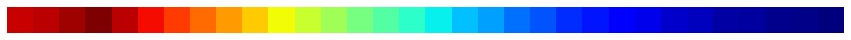

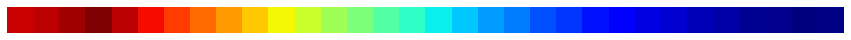

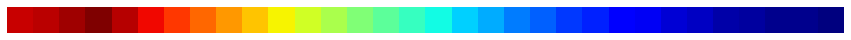

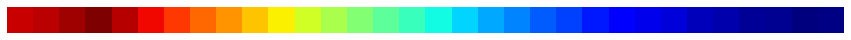

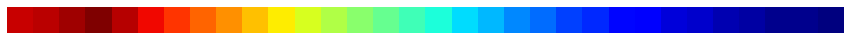

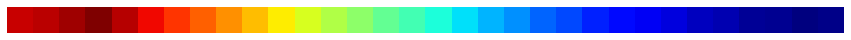

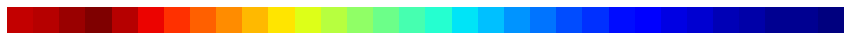

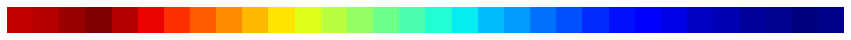

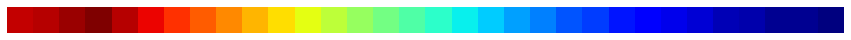

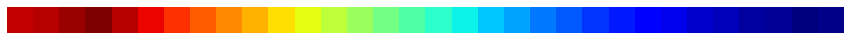

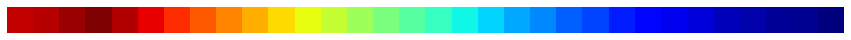

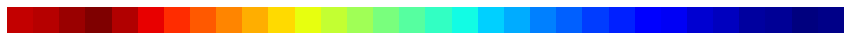

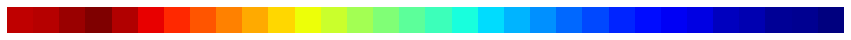

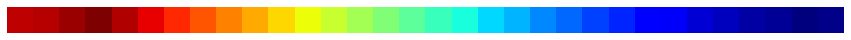

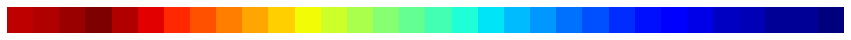

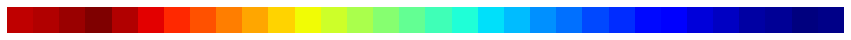

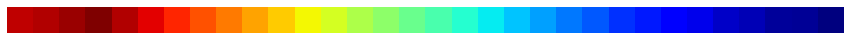

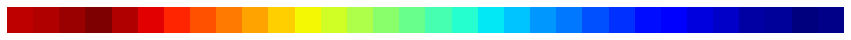

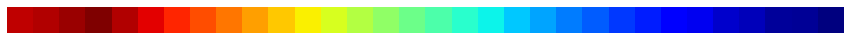

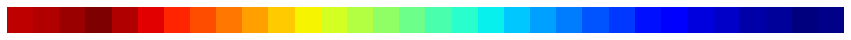

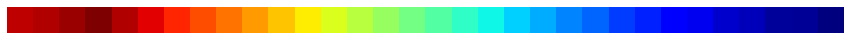

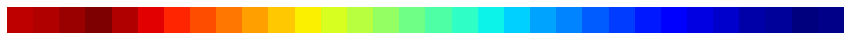

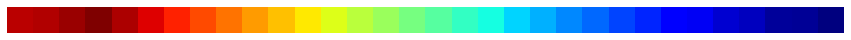

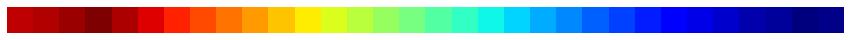

In [454]:
# number of cells within one single tissue
cells = np.zeros((32,1))


# QC cell starts with an initial amount of auxin
cells[3] = 600

plt.figure(figsize=(15,1))
plt.axis('off')
plt.imshow(cells.T)

cells_out = cells
for t in np.arange(0, sim_time, time_step):
    cells_out = update(cells_out)
#     print(cells_out.T)
    plt.figure(figsize=(15,1))
    plt.imshow(cells_out.T, cmap="jet")
    plt.axis('off')
    plt.draw()
    plt.pause(0.001)

In [442]:
neighbours = cells[list(filter(lambda x: x >= 0 and x < len(cells), v + 0))]
T=0.4
neighbours.shape[0] ==1
#transport_in = T*np.dot(P_in[index,:],neighbours)

True